In [156]:
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

In [5]:
os.chdir('/Users/amitrc/Documents/Machine Learning/Data/rsna-pneumonia-detection-challenge')

In [6]:
df_labels = pd.read_csv('rsna_heart_detection.csv')
df_labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [20]:
len(df_labels)

496

In [7]:
TRAIN_IMAGES = 'stage_2_train_images/'
SAVE_PATH = 'Processed_Heart_Detection'

## Show some sample images with the bounding boxes

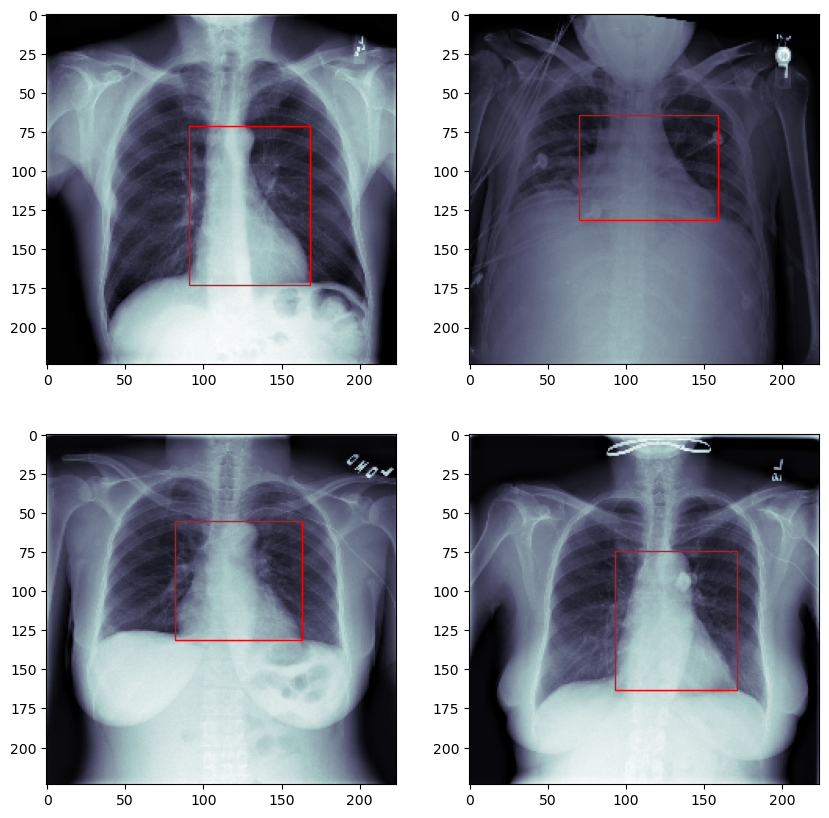

In [13]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

c = 0

for i in range(2):
    for j in range(2):
        
        data = df_labels.iloc[c]
        
        patient_id = data['name']
        path = TRAIN_IMAGES + patient_id + '.dcm'
        img = pydicom.read_file(path).pixel_array
        img = cv2.resize(img, (224, 224))
        
        # show the heart image
        ax[i][j].imshow(img, cmap='bone')
        
        # show the bounding box (already resized)
        x, y, w, h = data['x0'], data['y0'], data['w'], data['h']
        rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')

        ax[i][j].add_patch(rect)
        
        c += 1
        

  ## Calculate the Mean and Std for normalizing the data

In [25]:
sums, sums_squared = 0, 0

train_ids = []
val_ids = []
train_size = 400

os.makedirs(SAVE_PATH + '/train', exist_ok=True)
os.makedirs(SAVE_PATH + '/val', exist_ok=True)

for idx, patient_id in enumerate(df_labels['name']):
        
    # Read in the image and resize it
    path = TRAIN_IMAGES + patient_id + '.dcm'
    img = pydicom.read_file(path).pixel_array
    img = (cv2.resize(img, (224, 224)) / 255).astype(np.float16)
    
    train_or_val = 'train' if idx < train_size else 'val'
    
    normalizer = 224 * 224
    
    if train_or_val == 'train':
        train_ids.append(patient_id)        
        sums += np.sum(img) / normalizer
        sums_squared += (img ** 2).sum() / normalizer
    else:
        val_ids.append(patient_id)
        
    np.save(f"{SAVE_PATH}/{train_or_val}/{patient_id}.npy", img)


In [45]:
np.save(f"{SAVE_PATH}/train_subjects", train_ids)
np.save(f"{SAVE_PATH}/val_subjects", val_ids)

In [29]:
mean = sums / train_size
std = np.sqrt((sums_squared / train_size) - mean ** 2)

mean, std

(0.49484454719387716, 0.25282666925478103)

## Create the Data Generators

In [39]:
import torch
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [413]:
class CardiacDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_labels, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels)
        self.patients = np.load(patients)
        self.root_path = root_path
        self.augment = augs
        
    def __len__(self):
        
        return len(self.patients)
    
    def __getitem_amit__(self, idx):
        
        patient = self.patients[idx]
        data = self.labels[self.labels['name']==patient]
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        
        bbox = [x_min, y_min, x_max, y_max]
        
        file_path = f"{self.root_path}/{patient}.npy"
        img = np.load(file_path).astype(np.float32)
        
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
                        
            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
        
        # Normalize
        img = (img - 0.494) / 0.252
        img = torch.tensor(img).unsqueeze(0)
        box = torch.tensor(bbox)
                
        return img, bbox
            
        
    def __getitem__(self, idx):

        patient = self.patients[idx]
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]

        # Load file and convert to float32
        file_path = f"{self.root_path}/{patient}.npy"  # Create the path to the file
        img = np.load(f"{file_path}").astype(np.float32)
        
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox

#### Check that the dataset is created correctly

In [414]:
import imgaug.augmenters as iaa

In [415]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(scale=(0.8, 1.2), rotate=(-10, 10), translate_px=(-10, 10))
])

In [416]:
labels_path = "rsna_heart_detection.csv"
patients_path = f"{SAVE_PATH}/train_subjects.npy"
train_root = f"{SAVE_PATH}/train/"

dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

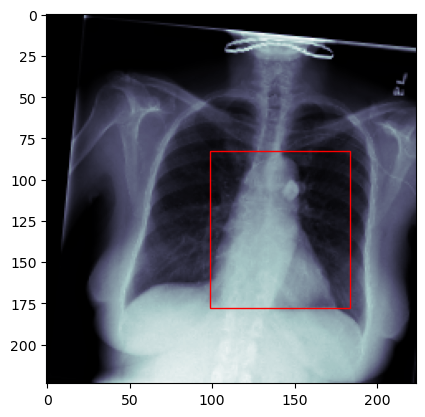

In [417]:
img, bbox = dataset[3]

fig, ax = plt.subplots(1,1)
ax.imshow(img[0], cmap='bone')
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='r', facecolor='none')
ax.add_patch(rect);

# Training Start

In [394]:
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [395]:
ROOT_PATH = 'Processed_Heart_Detection'

train_root_path = f"{ROOT_PATH}/train"
val_root_path = f"{ROOT_PATH}/val"

train_subjects = f"{ROOT_PATH}/train_subjects.npy"
val_subjects = f"{ROOT_PATH}/val_subjects.npy"

labels_path = "rsna_heart_detection.csv"

In [396]:
train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(scale=(0.8, 1.2), rotate=(-10, 10), translate_px=(-10, 10))
])

#### Create the datasets

In [418]:
train_dataset = CardiacDataset(labels_path, train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset(labels_path, val_subjects, val_root_path, None)

#### Create the Data Loaders

In [437]:
BATCH_SIZE = 8
NUM_WORKERS = 8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Define the Class

In [438]:
class CardiacModel(pl.LightningModule):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torchvision.models.resnet18(weights=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        
        return self.model(data)
        
    def training_step(self, batch, batch_idx):
        
        x_ray, label = batch
        label = label.float()
        
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x_ray, label = batch
        label = label.float()
        
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
            
        return loss

    def log_images(self, x_ray, pred, label, name):
 
        results = []
    
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0,0,0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0,0,0), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
            
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):

        return [self.optimizer]

In [462]:
model = CardiacModel()

/Users/amitrc/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [463]:
checkpoint_callback = ModelCheckpoint(
        monitor="Val Loss",
        save_top_k=10,
        mode="min"
)

In [465]:
trainer = pl.Trainer(logger=TensorBoardLogger("./logs"), 
                     log_every_n_steps=1, 
                     callbacks=checkpoint_callback,
                     max_epochs=100)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [466]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/amitrc/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/amitrc/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [468]:
%reload_ext tensorboard

In [469]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6007 (pid 18133), started 0:15:45 ago. (Use '!kill 18133' to kill it.)

# Evaluate the model

In [471]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Load the last model from the latest version

In [484]:
model_final = model.load_from_checkpoint("logs/lightning_logs/version_2/checkpoints/epoch=98-step=4950.ckpt")
model_final.eval();
model_final.to(device);

/Users/amitrc/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [495]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model_final(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds = torch.stack(preds)
labels = torch.stack(labels)

In [500]:
average_acuracy = (preds - labels).mean(0)
average_acuracy

tensor([-4.2087, -3.4824,  4.2141,  0.1230])

In [501]:
average_acuracy.mean()

tensor(-0.8385)

#### Visualize the results

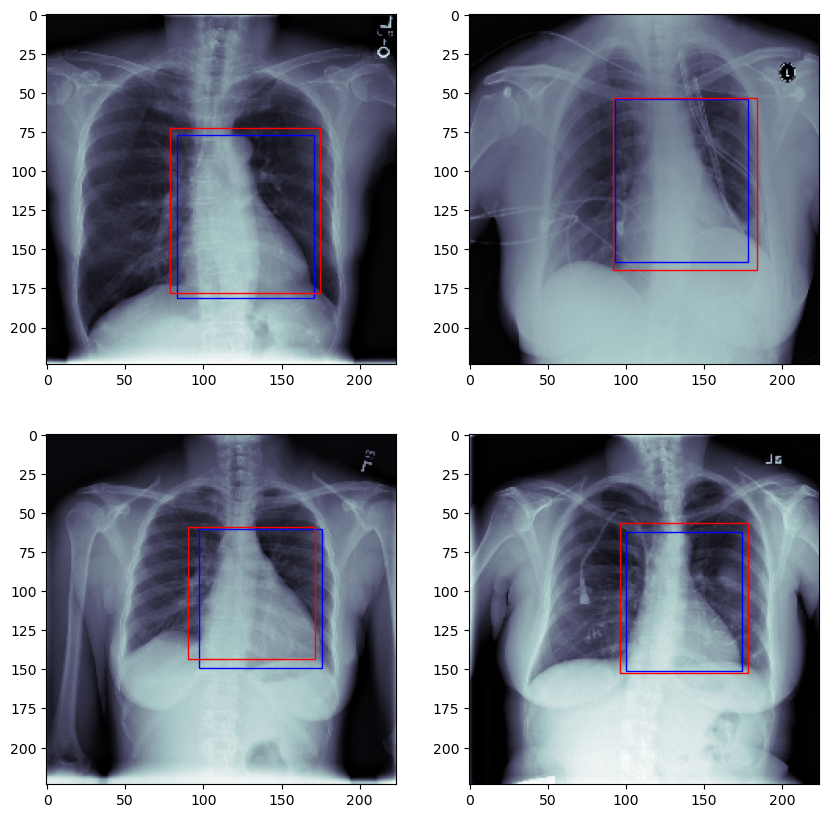

In [527]:
fix, ax = plt.subplots(2,2, figsize=(10,10))
IDX = [5, 10, 20, 39]

for i in range(2):
    for j in range(2):
        idx = IDX[2*i + j]
        
        data, label = val_dataset[idx]
        pred = preds[idx]

        # show the xray
        ax[i][j].imshow(data[0], cmap='bone');

        # show the actual bounding box
        actual_heart = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='b', facecolor='none')
        ax[i][j].add_patch(actual_heart)

        pred_heart = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], edgecolor='r', facecolor='none')
        ax[i][j].add_patch(pred_heart);